In [1]:
# 1.导入相应的模块

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import impute
from sklearn import datasets
from sklearn import model_selection
from sklearn import ensemble
from sklearn import metrics

In [2]:
# 2.导入波士顿房价数据集，并查看相应数据状态

boston = datasets.load_boston()

#总共506*13=6578个数据
print(boston.data.shape) #(506, 13)
print()
print(boston.target.shape) #(506,)
print()

X_full, y_full = boston.data, boston.target
n_samples = X_full.shape[0]
n_features = X_full.shape[1]

print(n_samples) #506
print()
print(n_features) #13
print()

(506, 13)

(506,)

506

13



In [3]:
# 3.为完整数据集放入缺失值

#首先确定我们希望放入的缺失数据的比例，在这里我们假设是50%，那总共就要有3289个数据缺失
rng = np.random.RandomState(0) #设置随机性，不用每次在函数内部去设置
missing_rate = 0.5 #缺失数据的比例
n_missing_samples = int(np.floor(n_samples * n_features * missing_rate)) #np.floor向下取整，返回.0格式的浮点数

#创造一个数组，包含3289个分布在0~506中间的行索引，和3289个分布在0~13之间的列索引，利用索引来为数据中的任意3289个位置赋空值
#然后我们用0，均值和随机森林来填写这些缺失值，然后查看回归的结果如何
missing_features = rng.randint(0,n_features,n_missing_samples) #randint(下限,上限,n) 请在上限和下限直接取出n个整数
missing_samples = rng.randint(0,n_samples,n_missing_samples)

#我们现在采样了3289个数据，远远超过我们的样本量506，所以我们使用随机抽取的函数randint。
#但如果我们需要的数据量小于我们的样本量506，那我们可以采用np.random.choice来抽样
#choice会随机抽取不重复的随机数，因此可以帮助我们让数据更加分散，确保数据不会集中在一些行中
#missing_samples = rng.choice(dataset.data.shape[0],n_missing_samples,replace=False)
X_missing = X_full.copy()
y_missing = y_full.copy()
X_missing[missing_samples,missing_features] = np.nan
X_missing = pd.DataFrame(X_missing) #转换成DataFrame方便后续各种操作，numpy对矩阵的运算速度快，但是在索引等功能上却不如pandas

In [15]:
# 4.使用均值或0填充缺失值

#使用均值进行填补
imp_mean = impute.SimpleImputer(missing_values=np.nan, strategy='mean') #missing_values:被填补的值，strategy:填补策略
X_missing_mean = imp_mean.fit_transform(X_missing) #fit_transform=训练(fit)+导出(predict)

#使用0进行填补
imp_0 = impute.SimpleImputer(missing_values=np.nan, strategy="constant",fill_value=0) #constant:常数，fill_value:被填补常数值
X_missing_0 = imp_0.fit_transform(X_missing)

#验证有无空值
pd.DataFrame(X_missing_mean).isnull().sum()

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
dtype: int64

In [4]:
# 5.使用随机森林填补缺失值

X_missing_reg = X_missing.copy()
sortindex = np.argsort(X_missing_reg.isnull().sum(axis=0)).values #把特征用缺失值的数量进行排序，由小到大
for i in sortindex:
    #构建我们的新特征矩阵和新标签
    df = X_missing_reg
    fillc = df.iloc[:,i]
    df = pd.concat([df.iloc[:,df.columns != i],pd.DataFrame(y_full)],axis=1)
    
    #在新特征矩阵中，对含有缺失值的列，进行0的填补
    df_0 = impute.SimpleImputer(missing_values=np.nan,
                        strategy='constant',fill_value=0).fit_transform(df)
    
    #找出我们的训练集和测试集
    Ytrain = fillc[fillc.notnull()]
    Ytest = fillc[fillc.isnull()]
    Xtrain = df_0[Ytrain.index,:]
    Xtest = df_0[Ytest.index,:]
    
    #用随机森林回归来填补缺失值
    rfc = ensemble.RandomForestRegressor(n_estimators=100)
    rfc = rfc.fit(Xtrain, Ytrain)
    Ypredict = rfc.predict(Xtest)
    
    #将填补好的特征返回到我们的原始的特征矩阵中
    X_missing_reg.loc[X_missing_reg.iloc[:,i].isnull(),i] = Ypredict

In [23]:
# 6.对填补好的数据进行建模

#对所有数据进行建模，取得MSE结果
X = [X_full,X_missing_mean,X_missing_0,X_missing_reg]
mse = []
std = []
for x in X:
    estimator = ensemble.RandomForestRegressor(random_state=0, n_estimators=100)
    scores = model_selection.cross_val_score(estimator,x,y_full,scoring='neg_mean_squared_error',
cv=5).mean()
    mse.append(scores * -1)

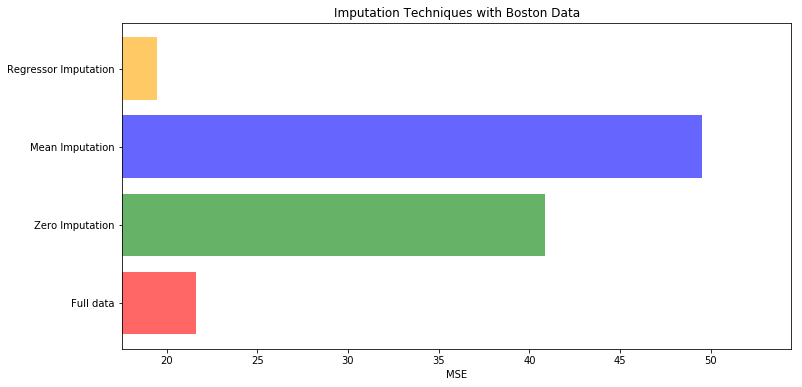

In [24]:
# 7.用所得结果画出条形图
x_labels = ['Full data',
            'Zero Imputation',
            'Mean Imputation',
            'Regressor Imputation']
colors = ['r', 'g', 'b', 'orange']
plt.figure(figsize=(12, 6))
ax = plt.subplot(111)
for i in np.arange(len(mse)):
    ax.barh(i, mse[i],color=colors[i], alpha=0.6, align='center')
ax.set_title('Imputation Techniques with Boston Data')
ax.set_xlim(left=np.min(mse) * 0.9,
             right=np.max(mse) * 1.1)
ax.set_yticks(np.arange(len(mse)))
ax.set_xlabel('MSE')
ax.set_yticklabels(x_labels)
plt.show()